# Import Data and Train Model


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision.transforms import ToTensor, Lambda
import torchvision.transforms as T
from transformers import get_scheduler, AdamW
from datasets import load_metric

import numpy as np
from scipy.io import wavfile
from scipy.fft import fft, fftfreq, fftshift
from scipy.fftpack import dct
import IPython.display
import librosa
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import pandas as pd;
import numpy as np
import math

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import mne
import mne.channels
from tqdm.auto import tqdm


## Load Data: Create Dataset


### Load Absence Seizure Data


In [6]:
class AbsenceDataset(Dataset):
    def __init__(self, file_path, transform=None, target_transform=None):
        self.x, self.y = self.data_get(file_path)
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

    def data_get(self, file_path):
        data = pd.read_csv(file_path)
        x_loaded, y_loaded = [], []
        for index, row in data.iterrows():
            a = np.load(row["labels"])
            for i, v in enumerate(a):
                a[i] = int(v)
            y_loaded.append(a)

            x_loaded.append(np.load(row["data"]))

        continuous_x = np.concatenate(x_loaded, axis=0)
        continuous_y = np.concatenate(y_loaded, axis=0)

        return continuous_x, continuous_y

In [7]:
%%capture
# Load the dataset
dataset = AbsenceDataset(
    "processed_data/absence/two_second_windows/epochs_files.csv",
    transform=torch.tensor,
    target_transform=torch.tensor,
)
dataset.y = dataset.y.astype(int)

In [8]:
dataset.x.shape

(8292, 5, 500)

# Split Data

70%, 20%, 10%


In [9]:
dataset_len = len(dataset)
dataset_len

8292

In [10]:
if (
    int(dataset_len * 0.7) + int(dataset_len * 0.2) + int(dataset_len * 0.1)
) != dataset_len:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            math.ceil(dataset_len * 0.7),
            int(dataset_len * 0.2),
            int(dataset_len * 0.1),
        ],
    )
else:
    train_set, eval_set, test_set = random_split(
        dataset,
        [
            int(dataset_len * 0.1),
            int(dataset_len * 0.7),
            int(dataset_len * 0.2),
        ],
    )

print(f"Train Split: {len(train_set)}")
print(f"Eval Split: {len(eval_set)}")
print(f"Test Split: {len(test_set)}")
print(f"Total: {len(train_set) + len(eval_set) + len(test_set)}")

Train Split: 5805
Eval Split: 1658
Test Split: 829
Total: 8292


In [11]:
train_set.dataset.x[train_set.indices].shape, train_set.dataset.y[
    train_set.indices
].shape

((5805, 5, 500), (5805,))

## Random Undersampling


In [12]:
bk, sz = 0, 0
for i, v in enumerate(train_set.dataset.y[train_set.indices]):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // Absence Seizure: {sz}")

Background: 5558 // Absence Seizure: 247


In [13]:
shape = train_set.dataset.x[train_set.indices].shape
data_reshaped = train_set.dataset.x[train_set.indices]
data_reshaped = np.reshape(data_reshaped, (shape[0], shape[1] * shape[2]))
data_reshaped.shape

(5805, 2500)

In [14]:
rand_us = RandomUnderSampler(random_state=42)
train_set_x, train_set_y = rand_us.fit_resample(
    data_reshaped, train_set.dataset.y[train_set.indices]
)

In [15]:
train_set_x = np.reshape(train_set_x, (train_set_x.shape[0], shape[1], shape[2]))
val_set_x = eval_set.dataset.x[eval_set.indices]
train_set_x.shape, val_set_x.shape

((494, 5, 500), (1658, 5, 500))

In [16]:
bk, sz = 0, 0
for i, v in enumerate(train_set_y):
    if v == 1:
        sz += 1
    else:
        bk += 1

print(f"Background: {bk} // Absence Seizure: {sz}")

Background: 247 // Absence Seizure: 247


# STFT


Create STFT


In [17]:
n_fft = int(512 / 2)
window = "taylor"
hop_length = int(n_fft / 6)
fmin = 0
fmax = 5
n_mels = 7
sample_rate = 250

# Train
stft_channel_data = []
for i, channels in enumerate(train_set_x):
    stft_channel_data.append(
        (
            librosa.feature.melspectrogram(
                y=channels,
                sr=sample_rate,
                n_mels=n_mels,
                n_fft=n_fft,
                fmin=fmin,
                fmax=fmax,
                hop_length=hop_length,
                window=window,
                center=True,
                pad_mode="constant",
                power=3.0,
            )
        )
    )
stft_channel_data = np.array(stft_channel_data)

# Val
val_stft_channel_data = []
for i, channels in enumerate(val_set_x):
    val_stft_channel_data.append(
        (
            librosa.feature.melspectrogram(
                y=channels,
                sr=sample_rate,
                n_mels=n_mels,
                n_fft=n_fft,
                fmin=fmin,
                fmax=fmax,
                hop_length=hop_length,
                window=window,
                center=True,
                pad_mode="constant",
                power=3.0,
            )
        )
    )
val_stft_channel_data = np.array(val_stft_channel_data)

stft_channel_data.shape, val_stft_channel_data.shape

((494, 5, 7, 12), (1658, 5, 7, 12))

In [18]:
# Train
train_db = []
for i, channels in enumerate(stft_channel_data):
    train_db.append(librosa.amplitude_to_db((channels), ref=np.max))
train_db = np.array(train_db)

# Val
val_db = []
for i, channels in enumerate(val_stft_channel_data):
    val_db.append(librosa.amplitude_to_db((channels), ref=np.max))
val_db = np.array(val_db)

train_db.shape, val_db.shape

((494, 5, 7, 12), (1658, 5, 7, 12))

In [19]:
# Train
train_db_mean = []
for i, channels in enumerate(stft_channel_data):
    train_db_mean.append(np.mean(channels, axis=0))
train_db_mean = np.array(train_db_mean)

# Val
val_db_mean = []
for i, channels in enumerate(val_stft_channel_data):
    val_db_mean.append(np.mean(channels, axis=0))
val_db_mean = np.array(val_db_mean)

train_db_mean.shape, val_db_mean.shape

((494, 7, 12), (1658, 7, 12))

In [20]:
x = 458
print(train_set_y[x])

1


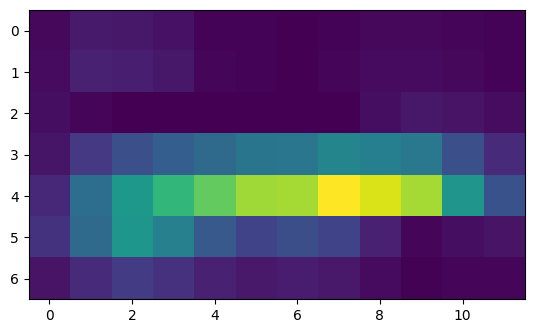

In [21]:
plt.imshow(train_db_mean[x])

Text(0.5, 1.0, 'Raw Channels')

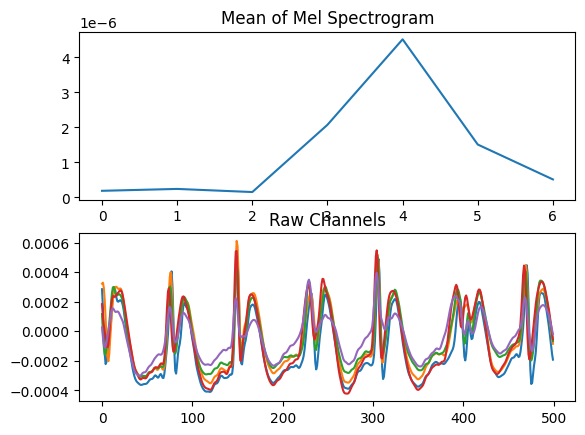

In [22]:
plt.subplot(2, 1, 1)
plt.plot(np.mean(train_db_mean[x], axis=1))
plt.title("Mean of Mel Spectrogram")
plt.subplot(2, 1, 2)
for i in train_set_x[x]:
    plt.plot(i)
plt.title("Raw Channels")

In [23]:
np.mean(train_db_mean[x], axis=1).shape, np.mean(train_db_mean[x], axis=1)

((7,),
 array([1.88699942e-07, 2.42614209e-07, 1.53510071e-07, 2.07554704e-06,
        4.51795756e-06, 1.51115316e-06, 5.13996460e-07]))

In [24]:
final_train_data = []
for i, v in enumerate(train_db_mean):
    final_train_data.append(np.mean(v, axis=1))
final_train_data = np.array(final_train_data)

final_val_data = []
for i, v in enumerate(val_db_mean):
    final_val_data.append(np.mean(v, axis=1))
final_val_data = np.array(final_val_data)

In [25]:
final_train_data[x].shape, final_train_data[x]

((7,),
 array([1.88699942e-07, 2.42614209e-07, 1.53510071e-07, 2.07554704e-06,
        4.51795756e-06, 1.51115316e-06, 5.13996460e-07]))

Display STFT


# Remake Dataset


In [26]:
class BalancedDataset(Dataset):
    def __init__(self, data, transform=None, target_transform=None):
        self.x, self.y = data
        self.n_samples = len(self.x)

        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]

        if self.transform:
            sample_x = self.transform(sample_x)

        if self.target_transform:
            sample_y = self.target_transform(sample_y)

        return sample_x.float(), sample_y.float()

    def __len__(self):
        return self.n_samples

In [27]:
new_balanced_train_dataset = BalancedDataset(
    (final_train_data, train_set_y),
    transform=torch.tensor,
    target_transform=torch.tensor,
)
mfcc_eval_dataset = BalancedDataset(
    (final_val_data, eval_set.dataset.y[eval_set.indices]),
    transform=torch.tensor,
    target_transform=torch.tensor,
)

In [ ]:
# # Train
# train_db = []
# for i, channels in enumerate(stft_channel_data):
#     train_db.append(librosa.amplitude_to_db((channels), ref=np.max))
# train_db = np.array(train_db)

# # Val
# val_db = []
# for i, channels in enumerate(val_stft_channel_data):
#     val_db.append(librosa.amplitude_to_db((channels), ref=np.max))
# val_db = np.array(val_db)

# train_db.shape, val_db.shape

# Visualize Data


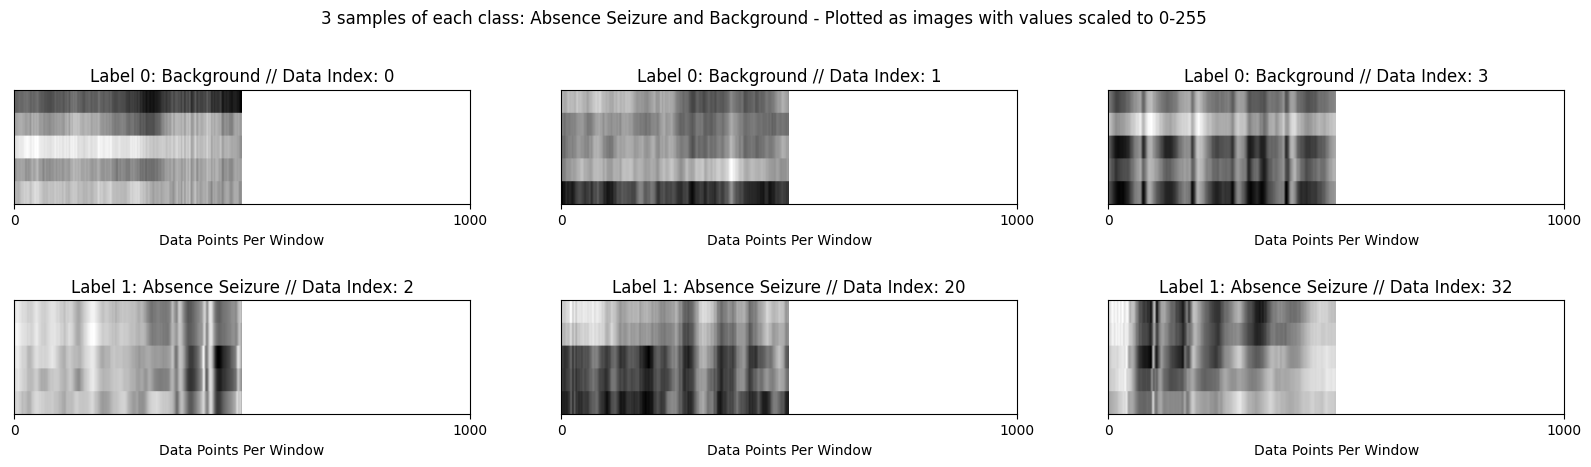

In [28]:
# Plot 3 of each class
fig, axs = plt.subplots(2, 3, figsize=(20, 5))
fig.suptitle(
    "3 samples of each class: Absence Seizure and Background - Plotted as images with values scaled to 0-255"
)

c1 = 0
c0 = 0

for i, v in enumerate(train_set.dataset.y[train_set.indices]):
    if v == 0 and c0 < 3:
        clone = train_set.dataset.x[train_set.indices][i]
        max_pixel = 0
        min_pixel = 0
        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                if n > max_pixel:
                    max_pixel = n
                if n < min_pixel:
                    min_pixel = n

        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                a = clone[m][j] - min_pixel
                b = 255 / (max_pixel - min_pixel)
                norm = a * b
                if norm > 255:
                    norm = 255
                if norm < 0:
                    norm = 0
                clone[m][j] = norm

        # Increase image size for better visibility if needed
        clone = np.repeat(clone, 50, axis=0)

        axs[0, c0].imshow(clone, cmap="gray")
        axs[0, c0].set_title(f"Label 0: Background // Data Index: {i}")
        axs[0, c0].set_yticks([])
        axs[0, c0].set_xticks([0, 1000])
        axs[0, c0].set_xlabel("Data Points Per Window")

        c0 += 1

    if v == 1 and c1 < 3:
        clone = train_set.dataset.x[train_set.indices][i]
        max_pixel = 0
        min_pixel = 0

        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                if n > max_pixel:
                    max_pixel = n
                if n < min_pixel:
                    min_pixel = n

        for m, b in enumerate(clone):
            for j, n in enumerate(clone[m]):
                a = clone[m][j] - min_pixel
                b = 255 / (max_pixel - min_pixel)
                norm = a * b
                if norm > 255:
                    norm = 255
                if norm < 0:
                    norm = 0
                clone[m][j] = norm

        # Increase image size for better visibility if needed
        clone = np.repeat(clone, 50, axis=0)

        axs[1, c1].imshow(clone, cmap="gray")
        axs[1, c1].set_title(f"Label 1: Absence Seizure // Data Index: {i}")
        axs[1, c1].set_yticks([])
        axs[1, c1].set_xticks([0, 1000])
        axs[1, c1].set_xlabel("Data Points Per Window")

        c1 += 1

    if c1 == 3 and c0 == 3:
        break

    # new_img = Image.fromarray(clone)

In [ ]:
# Plot 3 of each class
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("3 samples of each class")
c0 = 0
c1 = 0
for i, v in enumerate(train_set.dataset.x[train_set.indices]):
    if c0 < 3 and train_set.dataset.y[train_set.indices][i] == 0:
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][0], label="Channel 1")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][1], label="Channel 2")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][2], label="Channel 3")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][3], label="Channel 4")
        axs[0, c0].plot(train_set.dataset.x[train_set.indices][i][4], label="Channel 5")
        axs[0, c0].legend(loc="upper right")
        axs[0, c0].set_title(f"Label 0: Background // Data Index: {i}")
        c0 += 1
    elif c1 < 3 and train_set.dataset.y[train_set.indices][i] == 1:
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][0], label="Channel 1")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][1], label="Channel 2")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][2], label="Channel 3")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][3], label="Channel 4")
        axs[1, c1].plot(train_set.dataset.x[train_set.indices][i][4], label="Channel 5")
        axs[1, c1].legend(loc="upper right")
        axs[1, c1].set_title(f"Label 1: Absence Seizure // Data Index: {i}")
        c1 += 1

    if c0 == 3 and c1 == 3:
        break
plt.show()

In [ ]:
# Plot 3 of each class
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
fig.suptitle("3 samples of each class")
c0 = 0
c1 = 0
for i, v in enumerate(x_train_reshaped):
    if c0 < 3 and train_set.dataset.y[train_set.indices][i] == 0:
        axs[0, c0].plot(x_train_reshaped[i])
        axs[0, c0].set_title(f"Label 0: Background // Data Index: {i}")
        c0 += 1
    elif c1 < 3 and train_set.dataset.y[train_set.indices][i] == 1:
        axs[1, c1].plot(x_train_reshaped[i])
        axs[1, c1].set_title(f"Label 1: Absence Seizure // Data Index: {i}")
        c1 += 1

    if c0 == 3 and c1 == 3:
        break
plt.show()

# DataLoaders


In [29]:
train_dataloader = DataLoader(
    dataset=new_balanced_train_dataset,
    batch_size=1,
    shuffle=True,
)
eval_dataloader = DataLoader(dataset=mfcc_eval_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)

# Model


## Model 1: CNN


### 1D Model


In [40]:
class AbnormalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input 5 Channels
        self.CNN1 = nn.Conv1d(in_channels=1, out_channels=20, kernel_size=2)
        self.MaxPool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.CNN2 = nn.Conv1d(in_channels=20, out_channels=30, kernel_size=2)
        self.MaxPool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.CNN3 = nn.Conv1d(in_channels=30, out_channels=45, kernel_size=1)
        self.MaxPool3 = nn.MaxPool1d(kernel_size=1, stride=1)

        self.global_avg = nn.AdaptiveAvgPool2d(1)

        # RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x38 and 6x100)
        self.fc1 = nn.Linear(in_features=1, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=40)
        self.output = nn.Linear(in_features=40, out_features=1)

    def forward(self, x):
        out = F.relu(self.CNN1(x))
        out = self.MaxPool1(out)

        out = F.relu(self.CNN2(out))
        out = self.MaxPool2(out)

        out = F.relu(self.CNN3(out))
        out = self.MaxPool3(out)

        out = self.global_avg(out)
        out = torch.flatten(out)

        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.output(out)
        return x


# Set device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = AbnormalNeuralNetwork().to(device)

# Calculate number of parameters in model
n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

# Print Model
model = model.to(device)

Number of parameters in model: 3,606


### 2D Model


In [84]:
class AbnormalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # Input 5 Channels
        self.CNN1 = nn.Conv2d(
            in_channels=1, out_channels=64, kernel_size=3, padding=(1, 0)
        )
        self.MaxPool1 = nn.MaxPool2d(kernel_size=(6, 6), stride=2)

        self.CNN2 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, padding=(1, 0)
        )
        self.MaxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.CNN3 = nn.Conv2d(
            in_channels=128, out_channels=1, kernel_size=3, padding=(1, 0)
        )
        self.MaxPool3 = nn.MaxPool2d(kernel_size=(1, 1), stride=2)

        # RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x260 and 5043x1024)
        self.fc1 = nn.Linear(260, 1024)
        # self.dropout1 = nn.Dropout(p=0.3)

        self.fc2 = nn.Linear(1024, 1024)
        # self.dropout2 = nn.Dropout(p=0.3)

        # Output Layer
        self.output = nn.Linear(in_features=1024, out_features=1)

    def forward(self, x):
        x = F.relu(self.CNN1(x))
        x = self.MaxPool1(x)

        x = F.relu(self.CNN2(x))
        x = self.MaxPool2(x)

        x = F.relu(self.CNN3(x))
        x = self.MaxPool3(x)

        x = torch.flatten(x)

        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))

        x = self.output(x)
        x = F.relu(x)
        return x


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = AbnormalNeuralNetwork().to(device)

# Calculate number of parameters in model
n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

# Print Model
model = model.to(device)
model

Number of parameters in model: 1,393,538


AbnormalNeuralNetwork(
  (CNN1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
  (MaxPool1): MaxPool2d(kernel_size=(6, 6), stride=2, padding=0, dilation=1, ceil_mode=False)
  (CNN2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
  (MaxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (CNN3): Conv2d(128, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
  (MaxPool3): MaxPool2d(kernel_size=(1, 1), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=260, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
  (output): Linear(in_features=1024, out_features=1, bias=True)
)

### 2D Model 2: CNN


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=10)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=10)
        self.global_avg = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(128, 164)
        self.fc2 = nn.Linear(164, 164)
        self.fc3 = nn.Linear(164, 1)

    def forward(self, out):
        out = self.pool(F.relu(self.conv1(out)))
        out = self.pool(F.relu(self.conv2(out)))
        out = self.pool(F.relu(self.conv3(out)))
        out = self.global_avg(out)
        out = torch.flatten(out)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = Net().to(device)

# Calculate number of parameters in model
n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

# Print Model
model = model.to(device)
model

## Model 2: Linear


### 1


In [97]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(7, 64)
        self.linear2 = nn.Linear(64, 124)
        self.linear3 = nn.Linear(124, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, out):
        out = F.relu(self.linear1(out))
        out = F.relu(self.linear2(out))
        out = F.relu(self.linear3(out))
        out = self.output(out)
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LinearRegression().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

n_params = 0
for x in model.parameters():
    n_params += len(torch.flatten(x))
print(f"Number of parameters in model: {n_params:,}")

Number of parameters in model: 16,637


## RNN


In [30]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.rnn = nn.RNN(
            input_size=7,
            hidden_size=78,
            num_layers=10,
            batch_first=True,
            nonlinearity="relu",
        )
        self.fc = nn.Linear(78, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[-1])
        return out


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RNN().to(device)

# Train


## Training Loop


### Print Inputs


In [31]:
# Plot distribution of the dataset before balancing
# 0 - Background epoch
# 1 - Absence seizure epoch

bk = 0
sz = 0
for i, v in enumerate(train_dataloader):
    if v[1].squeeze() == torch.tensor([1.0]):
        sz += 1
    else:
        bk += 1

print(f"Train // Background: {bk} // Absence Seizure: {sz}")

bk = 0
sz = 0
for i, v in enumerate(eval_dataloader):
    if v[1].squeeze() == torch.tensor([1.0]):
        sz += 1
    else:
        bk += 1

print(f"Validation // Background: {bk} // Absence Seizure: {sz}")

Train // Background: 247 // Absence Seizure: 247
Validation // Background: 1580 // Absence Seizure: 78


### Training


In [98]:
for i, v in enumerate(eval_dataloader):
    first_input = v[0]
    first_label = v[1]
    break

print(first_input.shape, first_label)

for i, v in enumerate(train_dataloader):
    first_input = v[0]
    first_label = v[1]
    break

print(first_input.shape, first_label)

torch.Size([1, 7]) tensor([0.])
torch.Size([1, 7]) tensor([0.])


In [104]:
num_epochs = 300
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
scheduler = get_scheduler(
    "linear",
    optimizer,
    num_warmup_steps=0,
    num_training_steps=num_epochs * len(train_dataloader),
)

In [105]:
# for batch in train_dataloader:
#         inputs, labels = batch
#         inputs, labels = inputs.to(device), labels.to(device)
#         plt.plot(inputs[0].cpu().numpy())
#         print(labels)
#         break

In [106]:
progress_bar = tqdm(range(num_epochs * len(train_dataloader)))

loss_track = []
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in train_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.squeeze()
        # print(inputs.shape, labels.shape)

        # print(type(inputs))
        # numpy_inputs = inputs.cpu().detach().numpy()
        # image = numpy_inputs.transpose(1, 2, 0)
        # image = image.astype("uint8")
        # image = Image.fromarray(image)
        # image.show()
        # print(labels)
        # break

        optimizer.zero_grad()

        outputs = model(inputs)

        # outputs = outputs.squeeze(-1)  # Not needed for LR
        # outputs = outputs.squeeze(-1)  # Not needed for LR

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        scheduler.step()
        progress_bar.update(1)

        loss_track.append(loss)
    # break

print("Done")

100%|██████████| 24700/24700 [01:07<00:00, 367.58it/s]


Done


In [108]:
metric = load_metric("glue", "mrpc")
model.eval()
tp, fp, tn, fn = 0, 0, 0, 0
results_list = []
for batch in eval_dataloader:
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)

    # inputs = inputs.squeeze(0)

    with torch.no_grad():
        outputs = model(inputs)
        outputs = outputs.squeeze(-1)  # Not needed for LR

    results_list.append(outputs)
    # print(outputs)
    if outputs > 0.5:
        if labels == 1:
            tp += 1
        else:
            fp += 1
    else:
        if labels == 0:
            tn += 1
        else:
            fn += 1

    # logits = outputs.logits
    # predictions = torch.argmax(logits, dim=-1)
    # metric.add_batch(predictions=outputs, references=labels)

# results = metric.compute()
# for i, v in enumerate(eval_dataloader):
#     if v[1].squeeze() == torch.tensor([1.0]):
#         print(results_list[i])

c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\datasets\load.py:756: FutureWarning: The repository for glue contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/glue/glue.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [109]:
print(f"True Positives: {tp}")
print(f"False Positives: {fp}")
print(f"True Negatives: {tn}")
print(f"False Negatives: {fn}")
print(results_list)
# Plot schedular graph

True Positives: 0
False Positives: 0
True Negatives: 1580
False Negatives: 78
[tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0449], device='cuda:0'), tensor([0.0

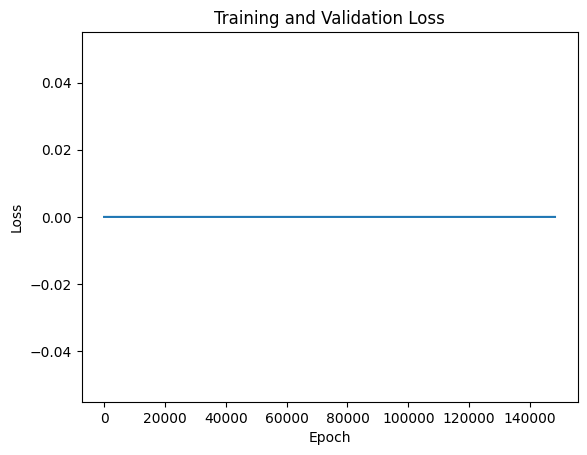

In [107]:
# Plot losses
a = []
for i in range(len(loss_track)):
    a.append(loss_track[i].item())

plt.plot(range(len(a)), a, label="Training Loss")
# plt.plot(range(len(loss_track_valid)), loss_track_valid, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [115]:
print(loss_track[4])

tensor(-0., device='cuda:0', grad_fn=<DivBackward1>)
